# Imports

In [1]:
import importlib
import sys
import torch

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')

In [2]:
!ls ../../../../../../ProbabilisticSuffixPredictionLab/risk_controlled_proactive_conformance_checking_dev/data/encoded_data/Helpdesk

helpdesk_all_normal_3_test.pkl	 helpdesk_all_normal_5_test.pkl
helpdesk_all_normal_3_train.pkl  helpdesk_all_normal_5_train.pkl
helpdesk_all_normal_3_val.pkl	 helpdesk_all_normal_5_val.pkl


# Data

### Load Data Files

In [3]:
# Path to your pickle file (saved with torch.save)
file_path_train = '../../../../../../ProbabilisticSuffixPredictionLab/risk_controlled_proactive_conformance_checking_dev/data/encoded_data/Helpdesk/helpdesk_all_normal_3_train.pkl'
# Load the dataset using torch.load
helpdesk_train_dataset = torch.load(file_path_train, weights_only=False)
# Check the type of the loaded dataset
print(type(helpdesk_train_dataset))  # Should output something like <class 'torch.utils.data.dataset.TensorDataset'>

# Path to your pickle file (saved with torch.save)
file_path_val = '../../../../../../ProbabilisticSuffixPredictionLab/risk_controlled_proactive_conformance_checking_dev/data/encoded_data/Helpdesk/helpdesk_all_normal_3_val.pkl'
# Load the dataset using torch.load
helpdesk_val_dataset = torch.load(file_path_val, weights_only=False)
# Check the type of the loaded dataset
print(type(helpdesk_val_dataset))  # Should output something like <class 'torch.utils.data.dataset.TensorDataset'>

<class 'event_log_loader.new_event_log_loader.EventLogDataset'>
<class 'event_log_loader.new_event_log_loader.EventLogDataset'>


### Train Data Insights

In [4]:
# Helpdesk Dataset Categories, Features:
helpdesk_all_categories = helpdesk_train_dataset.all_categories

helpdesk_all_categories_cat = helpdesk_all_categories[0]
print(helpdesk_all_categories_cat)

helpdesk_all_categories_num = helpdesk_all_categories[1]
print(helpdesk_all_categories_num)

for i, cat in enumerate(helpdesk_all_categories_cat):
     print(f"Helpdesk (5) Categorical feature: {cat[0]}, Index position in categorical data list: {i}")
     print(f"Helpdesk (5) Total Amount of Category labels: {cat[1]}")
print('\n')    
for i, num in enumerate(helpdesk_all_categories_num):
     print(f"Helpdesk (5) Numerical feature: {num[0]}, Index position in categorical data list: {i}")
     print(f"Helpdesk (5) Amount Numerical: {num[1]}")

[('Activity', 16, {'Assign seriousness': 1, 'Closed': 2, 'Create SW anomaly': 3, 'DUPLICATE': 4, 'EOS': 5, 'INVALID': 6, 'Insert ticket': 7, 'RESOLVED': 8, 'Require upgrade': 9, 'Resolve SW anomaly': 10, 'Resolve ticket': 11, 'Schedule intervention': 12, 'Take in charge ticket': 13, 'VERIFIED': 14, 'Wait': 15}), ('Resource', 24, {'EOS': 1, 'Value 1': 2, 'Value 10': 3, 'Value 11': 4, 'Value 12': 5, 'Value 13': 6, 'Value 14': 7, 'Value 15': 8, 'Value 16': 9, 'Value 17': 10, 'Value 18': 11, 'Value 19': 12, 'Value 2': 13, 'Value 20': 14, 'Value 21': 15, 'Value 22': 16, 'Value 3': 17, 'Value 4': 18, 'Value 5': 19, 'Value 6': 20, 'Value 7': 21, 'Value 8': 22, 'Value 9': 23}), ('VariantIndex', 161, {'1.0': 1, '10.0': 2, '100.0': 3, '104.0': 4, '107.0': 5, '109.0': 6, '11.0': 7, '110.0': 8, '112.0': 9, '113.0': 10, '114.0': 11, '115.0': 12, '117.0': 13, '118.0': 14, '12.0': 15, '120.0': 16, '122.0': 17, '123.0': 18, '124.0': 19, '125.0': 20, '129.0': 21, '13.0': 22, '130.0': 23, '131.0': 24, '

### Input Features for Encoder and Decoder

In [5]:
# Create lists with name of Encoder features (input) and decoder features (input & output)

# Encoder features:
enc_feat_cat = []
enc_feat_num = []
for cat in helpdesk_all_categories_cat:
    enc_feat_cat.append(cat[0])
for num in helpdesk_all_categories_num:
    enc_feat_num.append(num[0])
enc_feat = [enc_feat_cat, enc_feat_num]
print("Input features encoder: ", enc_feat)

"""
# Decoder features:
dec_feat_cat = enc_feat_cat
dec_feat_num = enc_feat_num
dec_feat = [dec_feat_cat, dec_feat_num]
print("Features decoder: ", dec_feat)
"""

# Decoder features:
dec_feat_cat = ['Activity']
dec_feat_num = ['case_elapsed_time', 'event_elapsed_time']
dec_feat = [dec_feat_cat, dec_feat_num]
print("Features decoder: ", dec_feat)

Input features encoder:  [['Activity', 'Resource', 'VariantIndex', 'seriousness', 'customer', 'product', 'responsible_section', 'seriousness_2', 'service_level', 'service_type', 'support_section', 'workgroup'], ['case_elapsed_time', 'event_elapsed_time', 'day_in_week', 'seconds_in_day']]
Features decoder:  [['Activity'], ['case_elapsed_time', 'event_elapsed_time']]


# Model

In [6]:
import model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model
importlib.reload(model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model)
from model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model import DropoutUncertaintyEncoderDecoderLSTM

# Check and try to get this out of the data objects

# Prediction decoder output sequence length

# min suffix size = 5
# seq_len_pred = 4
# min suffix size = 3
seq_len_pred = 2

# Size hidden layer
hidden_size = 128

# Number of cells
num_layers = 4

# Fixed Dropout probability 
dropout = 0.1

# Encoder Decoder model initialization
model = DropoutUncertaintyEncoderDecoderLSTM(data_set_categories=helpdesk_all_categories,
                                             enc_feat=enc_feat,
                                             dec_feat=dec_feat,
                                             seq_len_pred=seq_len_pred,
                                             hidden_size=hidden_size,
                                             num_layers=num_layers,
                                             dropout=dropout)

Data set categories:  ([('Activity', 16, {'Assign seriousness': 1, 'Closed': 2, 'Create SW anomaly': 3, 'DUPLICATE': 4, 'EOS': 5, 'INVALID': 6, 'Insert ticket': 7, 'RESOLVED': 8, 'Require upgrade': 9, 'Resolve SW anomaly': 10, 'Resolve ticket': 11, 'Schedule intervention': 12, 'Take in charge ticket': 13, 'VERIFIED': 14, 'Wait': 15}), ('Resource', 24, {'EOS': 1, 'Value 1': 2, 'Value 10': 3, 'Value 11': 4, 'Value 12': 5, 'Value 13': 6, 'Value 14': 7, 'Value 15': 8, 'Value 16': 9, 'Value 17': 10, 'Value 18': 11, 'Value 19': 12, 'Value 2': 13, 'Value 20': 14, 'Value 21': 15, 'Value 22': 16, 'Value 3': 17, 'Value 4': 18, 'Value 5': 19, 'Value 6': 20, 'Value 7': 21, 'Value 8': 22, 'Value 9': 23}), ('VariantIndex', 161, {'1.0': 1, '10.0': 2, '100.0': 3, '104.0': 4, '107.0': 5, '109.0': 6, '11.0': 7, '110.0': 8, '112.0': 9, '113.0': 10, '114.0': 11, '115.0': 12, '117.0': 13, '118.0': 14, '12.0': 15, '120.0': 16, '122.0': 17, '123.0': 18, '124.0': 19, '125.0': 20, '129.0': 21, '13.0': 22, '130

# Loss Object Creation

In [7]:
import loss.losses
importlib.reload(loss.losses)
from loss.losses import Loss

loss_obj = Loss()

# Training Configuration

In [8]:
import trainer.trainer
importlib.reload(trainer.trainer)
from trainer.trainer import Trainer
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(comment="Full_Helpdesk_grad_pro_conf_check")

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# lambda for L2 (weight, bias, dropout) regularization
# regularization_term = 1e-3

# Start learning rate
learning_rate = 1e-5

# Optimizer and Scheduler
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-10)

# Epochs
num_epochs = 100

# BATCHING does not work currntly with custom implementation
batch_size = 128

# lambda for L2 (weight, bias, dropout) regularization: According to formula: 1/2N
# regularization_term = 1.0/(2.0*batch_size)
regularization_term = 1e-4

# shuffle data
shuffle = True

# Teacher forcing: If teacher forcing is greater as 0.5 more targets are used else more predicted
teacher_forcing_ratio = 0.75

optimize_values = {"regularization_term":regularization_term,
                   "optimizer":optimizer,
                   "scheduler": scheduler,
                   "epochs":num_epochs,
                   "mini_batches":batch_size,
                   "shuffle": shuffle,
                   "teacher_forcing_ratio":teacher_forcing_ratio,}

# For prediction length during training
suffix_data_split_value = seq_len_pred

# GradNorm parameter
use_gradnorm = True
gn_alpha = 1.5
gn_learning_rate = 1e-4

number_tasks = len(dec_feat[0]) + len(dec_feat[1])

gradNorm = {"use_gradnorm":use_gradnorm,
            "number_tasks": number_tasks,
            "gn_alpha":gn_alpha,
            "gn_learning_rate": gn_learning_rate}

trainer = Trainer(device=device,
                  model=model,
                  data_train=helpdesk_train_dataset,
                  data_val=helpdesk_val_dataset,
                  loss_obj=loss_obj,
                  log_normal_loss_num_feature = [],
                  optimize_values=optimize_values,
                  suffix_data_split_value=suffix_data_split_value,
                  writer=writer,
                  gradnorm_values=gradNorm,
                  save_model_n_th_epoch = 1,
                  saving_path = 'Helpdesk_full_grad_norm_proactive_conf_check.pkl')

# Train the model:
train_attenuated_losses, val_losses, val_attenuated_losses = trainer.train_model()

Device:  cuda
Model:  DropoutUncertaintyEncoderDecoderLSTM(
  (embeddings_enc): ModuleList(
    (0): Embedding(16, 8)
    (1): Embedding(24, 9)
    (2): Embedding(161, 28)
    (3): Embedding(3, 3)
    (4): Embedding(346, 42)
    (5): Embedding(23, 9)
    (6): Embedding(9, 5)
    (7-9): 3 x Embedding(6, 4)
    (10): Embedding(8, 5)
    (11): Embedding(6, 4)
  )
  (encoder): DropoutUncertaintyLSTMEncoder(
    (embeddings): ModuleList(
      (0): Embedding(16, 8)
      (1): Embedding(24, 9)
      (2): Embedding(161, 28)
      (3): Embedding(3, 3)
      (4): Embedding(346, 42)
      (5): Embedding(23, 9)
      (6): Embedding(9, 5)
      (7-9): 3 x Embedding(6, 4)
      (10): Embedding(8, 5)
      (11): Embedding(6, 4)
    )
    (first_layer): DropoutUncertaintyLSTMCell(
      (Wi): Linear(in_features=129, out_features=128, bias=True)
      (Ui): Linear(in_features=128, out_features=128, bias=True)
      (Wf): Linear(in_features=129, out_features=128, bias=True)
      (Uf): Linear(in_featur

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Learning Rate: 1e-05, Teacher forcing ratio: 0.75
Training: Avg Attenuated Training Loss: 4.7123
Validation: Avg Standard Validation Loss: 5.1086
Validation: Avg Attenuated Validation Loss: 4.3834
Validation Loss for Scheduler: 5.1086
saving model
Epoch [2/100], Learning Rate: 1e-05, Teacher forcing ratio: 0.75
Training: Avg Attenuated Training Loss: 4.7138
Validation: Avg Standard Validation Loss: 5.0854
Validation: Avg Attenuated Validation Loss: 4.3602
Validation Loss for Scheduler: 5.0854
saving model
Epoch [3/100], Learning Rate: 1e-05, Teacher forcing ratio: 0.75
Training: Avg Attenuated Training Loss: 4.7086
Validation: Avg Standard Validation Loss: 5.0546
Validation: Avg Attenuated Validation Loss: 4.3254
Validation Loss for Scheduler: 5.0546
saving model
Epoch [4/100], Learning Rate: 1e-05, Teacher forcing ratio: 0.75
Training: Avg Attenuated Training Loss: 4.6767
Validation: Avg Standard Validation Loss: 4.9485
Validation: Avg Attenuated Validation Loss: 4.2181

# Training Visualization

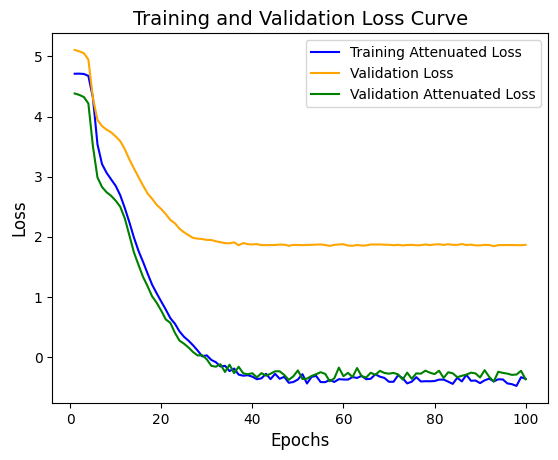

In [9]:
import matplotlib.pyplot as plt

# After training is finished, plot the loss curves
plt.plot(range(1, num_epochs+1), train_attenuated_losses, label='Training Attenuated Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='orange')
plt.plot(range(1, num_epochs+1), val_attenuated_losses, label='Validation Attenuated Loss', color='green')
# Labeling x and y axes
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
# Adding title
plt.title('Training and Validation Loss Curve', fontsize=14)
# Adding legend
plt.legend()
# Show the plot
plt.show()